In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


### Plot the number of ratings per movie and user

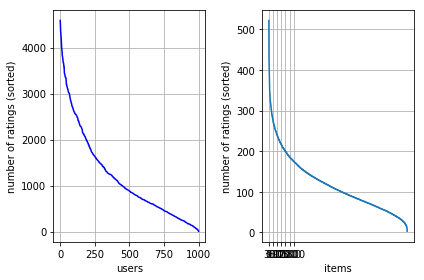

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]   #return only when it's true
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]   
    valid_ratings = ratings[valid_items, :][: , valid_users]  #Why not directly [valid_items,valid_users] ?  
    
    # ***************************************************
    # split the data and return train and test data. 
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    index = valid_ratings.nonzero()  #tuple of array 

    order_shuffled = np.arange(0,len(index[0]))
    np.random.shuffle(order_shuffled)
     
    index_shuffled = (index[0][order_shuffled],index[1][order_shuffled])

    test_index_size = int(p_test*len(order_shuffled))
    
    index_test = (index_shuffled[0][:test_index_size],index_shuffled[1][:test_index_size])
  
    index_train = (index_shuffled[0][test_index_size:],index_shuffled[1][test_index_size:])

    test[index_test] =  valid_ratings[index_test]
    
    train[index_train] = valid_ratings[index_train]
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in valid data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [6]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
#plot_train_test_data(train, test)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in valid data:1176873
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


## Implementing Baselines 

### Use the global mean to do the prediction

In [7]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    
    global_mean_train = train[train.nonzero()].mean()
    
    test_nonzero_dense = test[test.nonzero()].todense()
    
    mse = calculate_mse( test_nonzero_dense, global_mean_train )
    
    rmse = np.sqrt( mse / test_nonzero_dense.shape[1] )
    
    return rmse[0,0]
    
baseline_global_mean(train, test)

1.1171646234717394

### Use the user means as the prediction

In [8]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    count = 0 
    num_items, num_users = train.shape
    
    sums=train.sum(axis=0) #sum for each user
    
    mean_user=np.zeros((1,num_users))

    for j in range(0,num_users):
        if(sums[0,j] != 0):
            elems = train[:,j]
            elems_nonzero = elems[elems.nonzero()]
            mean_user[0,j] = elems_nonzero.mean()
    
        for i in range(test.shape[0]):
            if(test[i,j] != 0):
                mean_user_elem = mean_user[0,j]
                mse += (test[i,j]-mean_user_elem )**2
                count+= 1
   
    rmse = np.sqrt( mse / count )
    
    return rmse
baseline_user_mean(train, test)

1.0292372231810407

### Use the item means as the prediction

In [9]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    count = 0 
    num_items, num_users = train.shape
    
    sums=train.sum(axis=1) #sum for each user
    
    mean_item=np.zeros((num_items,1))

    for i in range(0,num_items):
        if(sums[i,0] != 0):
            elems = train[i,:]
            elems_nonzero = elems[elems.nonzero()]
            mean_item[i,0] = elems_nonzero.mean()
    
        for j in range(test.shape[1]):
            if(test[i,j] != 0):
                mean_item_elem = mean_item[i,0]
                mse += (test[i,j]-mean_item_elem)**2
                count+= 1
   
    rmse = np.sqrt( mse / count )
    
    return rmse
baseline_item_mean(train, test)

1.0919855243000396

The **item mean prediction** gives us the best approximation 

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [10]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    num_item, num_user = train.get_shape()
    
    user_features = np.random.rand(num_features,num_user)  #(K,N)
    item_features = np.random.rand(num_features,num_item)  #(K,D)
    
    #do we need to do anything else ? 
        
    return user_features,item_features

Compute the cost by the method of matrix factorization.


In [11]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse=0
    for row,col in nz:
        w_d = item_features[:,row]
        z_n = user_features[:,col]
        prediction= w_d @ z_n.T
        error_prediction = (data[row,col] - prediction ) **2 
        mse+=error_prediction
    
    return np.sqrt(mse / len(nz))

In [16]:
def matrix_factorization_SGD(train, test,reg=True):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)   #Z0.T,W0
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            
            item_data = item_features[:,d]  
            user_data = user_features[:,n]
            
            prediciton_error = train[d, n] - item_data @ user_data.T
        
            #compute derivative wrt w
            grad_w = -prediciton_error * user_data  
                
            #compute derivative wrt z 
            grad_z = -prediciton_error * item_data
   
            #update 
            if(reg):
            
                item_features[:,d]-= gamma * ( grad_w + lambda_item * item_data)
                user_features[:,n]-= gamma * ( grad_z + lambda_user * user_data)
            
            else:
                item_features[:,d]-= gamma * grad_w
                user_features[:,n]-= gamma * grad_z
        
        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    
    return item_features, user_features

item_features, user_features = matrix_factorization_SGD(train, test)    #Regularized


##matrix_factorization_SGD(train, test, False) #Not regularized

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0396454698328181.
iter: 1, RMSE on training set: 1.0349595382492598.
iter: 2, RMSE on training set: 1.0349705134397549.
iter: 3, RMSE on training set: 1.0329840001506103.
iter: 4, RMSE on training set: 1.0314520506262004.
iter: 5, RMSE on training set: 1.0300808532240444.
iter: 6, RMSE on training set: 1.0285397866898172.
iter: 7, RMSE on training set: 1.0273312057023696.
iter: 8, RMSE on training set: 1.0266935358979976.
iter: 9, RMSE on training set: 1.026072190435157.
iter: 10, RMSE on training set: 1.026056677957059.
iter: 11, RMSE on training set: 1.0256322871361312.
iter: 12, RMSE on training set: 1.0255265448223012.
iter: 13, RMSE on training set: 1.0253143200675616.
iter: 14, RMSE on training set: 1.0251330057401447.
iter: 15, RMSE on training set: 1.0252774077749784.
iter: 16, RMSE on training set: 1.025199164616075.
iter: 17, RMSE on training set: 1.0251349855343557.
iter: 18, RMSE on training set: 1

## Prediction for submission

In [33]:
import csv 

print(item_features.T.shape)
print(user_features.shape)

X = item_features.T @ user_features

with open('submission.csv' , 'w') as writeFile: 
    writer = csv.writer(writeFile)
    
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            if(X[i,j] != 0):
                s= "r{0}_c{1}".format(i+1,j+1)
                row= [s, str(X[i,j])]
                writer.writerows(row)

writeFile.close()

(9990, 20)
(20, 999)


### Learn the Matrix Factorization using Alternating Least Squares

In [20]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    
    
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * np.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[items, user]
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[item, users].T
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [21]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))

ALS(train, test)


start the ALS algorithm...
RMSE on training set: 1.2268608177178733.
RMSE on training set: 1.0679719056734243.
RMSE on training set: 1.011176082495169.
RMSE on training set: 0.9809366938195246.
RMSE on training set: 0.9626783232194683.
RMSE on training set: 0.9515927754786456.
RMSE on training set: 0.9448637043216529.
RMSE on training set: 0.940663999584706.
RMSE on training set: 0.937942581733915.
RMSE on training set: 0.9361197282526463.
RMSE on training set: 0.9348679291407508.
RMSE on training set: 0.9339931005581322.
RMSE on training set: 0.9333744071964116.
RMSE on training set: 0.9329333817287765.
RMSE on training set: 0.9326173771071264.
RMSE on training set: 0.932390212919941.
RMSE on training set: 0.9322265982307127.
RMSE on training set: 0.9321086434183049.
RMSE on training set: 0.9320235906035975.
test RMSE after running ALS: 0.9610301226500155.
